# Iterative lensing estimation demo (CMB-S4).

This notebook goes through an example of lensing iterative reconstruction, from polarization Q and U CMB data, with noise level of 2.12 $\mu$K-arcmin, on 650 square degrees, under ideal conditions (no masking, homogeneous noise, etc), with pixel size 1.5 arcmin. Specifically, we proceed as follows
1. We build the quadratic estimator and initial curvature estimates
2. We setup the iterator instance
3. We perform the iterations
4. We have a quick look at the quality of the lensing map reconstruction

It should take or minute or so to perform all iterations from the starting point.

Before starting, set the environment variable LENSIT to somewhere that is safe to write. A bunch of stuff might get cached.

In [1]:
%matplotlib inline
import pylab as pl
import numpy as np
import lensit as li
import os

### 1. We build the quadratic estimator and initial curvature estimates:

In [2]:
def get_starting_point(idx): 
    """
    This returns initial data for simulation index 'idx' from a CMB-S4 simulation library.
    On first call the simulation library will generate all simulations phases, hence might take a little while.
    """ 
    sims = li.get_maps_lib('S4', 10, 11) # Simulation-library for configuration 'S4'. 
                                         # Parameters 10, 11 produces data on 645 sq. deg, 
                                         # with lensed CMB's generated at 0.75 arcmin resolution, 
                                         # but data collected at 1.5 arcmin resolution. 
    
    isocov = li.get_isocov('S4', 10, 11) # Isotropic filtering instance, that can used for Q.E. calculation
                                         # and other things.isocov.lib_datalm defines the mode-filtering applied 
                                         # the data, and isocov.lib_skyalm the band-limits of the unlensed sky.
    print(" I will be using data from ell=%s to ell=%s only"%(isocov.lib_datalm.ellmin, isocov.lib_datalm.ellmax))
    print(" The sky band-limit is ell=%s"%(isocov.lib_skyalm.ellmax))
    
    lib_qlm = isocov.lib_skyalm #: This means we will reconstruct the lensing potential for all unlensed sky modes.
    def cli(cl):
        ret = np.zeros_like(cl)
        ret[np.where(cl > 0)] = 1./cl[np.where(cl > 0)]
        return ret
    
    # We now build the Wiener-filtered quadratic estimator. We use lensed CMB spectra in the weights.
    datalms = np.array([isocov.lib_datalm.map2alm(m) for m in sims.get_sim_qumap(idx)]) 
    H0len =  cli(isocov.get_N0cls('QU', lib_qlm, use_cls_len=True)[0])
    plm0 = 0.5 * isocov.get_qlms('QU',  isocov.get_iblms('QU', datalms, use_cls_len=True)[0], lib_qlm, 
                                 use_cls_len=True)[0]
    
    # Normalization and Wiener-filtering:
    cpp_prior = li.get_fidcls()[0]['pp'][:lib_qlm.ellmax+1]
    lib_qlm.almxfl(plm0, cli(H0len + cli(cpp_prior)), inplace=True)
    
    # Initial likelihood curvature guess. We use here N0 as calculated with unlensed CMB spectra:
    H0unl =  cli(isocov.get_N0cls('QU', lib_qlm, use_cls_len=False)[0])
    return plm0, lib_qlm, datalms, isocov.lib_datalm, H0unl, H0len

plm0, lib_qlm, datalms, lib_datalm, H0, H0len = get_starting_point(0)

 I will be using data from ell=14 to ell=3000 only
 The sky band-limit is ell=6000
     [00:00:00]  (total [00:00:00])   get_qlms::mult with len Pmat  
     [00:00:00]  (total [00:00:00])   get_qlms::cartesian gradients  
     [00:00:00]  (total [00:00:00])   get_qlms::rotation to phi Omega  


### 2. We setup the iterator instance:

In [3]:
from lensit.ffs_iterators.ffs_iterator import ffs_iterator_pertMF
from lensit.misc.misc_utils import gauss_beam
from lensit.qcinv import ffs_ninv_filt_ideal, chain_samples
from lensit.ffs_covs import ell_mat

def get_itlib(lib_dir, plm0, lib_qlm,  datalms, lib_datalm, H0, beam_fwhmamin=3., NlevT_filt=1.5, NlevP_filt=1.5 * np.sqrt(2.)):
    """
    This returns an iterator instance from the input data maps, lensing map starting point,
    likelihood curvature guess and choice of filtering parameters (ideally close to those of the data).
    """

    if not os.path.exists(lib_dir): 
        os.makedirs(lib_dir)
    # Prior on lensing power spectrum, and CMB spectra for the filtering at each iteration step.
    cls_unl = li.get_fidcls(6000)[0]
    cpp_prior = cls_unl['pp'][:]
    
    
    lib_skyalm = ell_mat.ffs_alm_pyFFTW(lib_datalm.ell_mat, filt_func=lambda ell:ell<=6000)
                            #: This means we perform here the lensing of CMB skies at the same resolution 
                            #  than the data with the band-limit of 6000.
    transf = gauss_beam(beam_fwhmamin / 180. / 60. * np.pi, lmax=6000) #: fiducial beam
    
    # Anisotropic filtering instance, with unlensed CMB spectra as inputs. Delfections will be added by the iterator.
    filt = ffs_ninv_filt_ideal.ffs_ninv_filt(lib_datalm, lib_skyalm, cls_unl, transf, NlevT_filt,NlevP_filt)
    
    # Description of the multi-grid chain to use: (here the simplest, diagonal pre-conditioner) 
    chain_descr = chain_samples.get_isomgchain(filt.lib_skyalm.ellmax,filt.lib_datalm.shape,
                                                        tol=1e-6,iter_max=200)
    
    # We assume no primordial B-modes, the E-B filtering will assume all B-modes are either noise or lensing:
    opfilt =  li.qcinv.opfilt_cinv_noBB
    opfilt._type = 'QU' # We consider polarization only
    
    # With all this now in place, we can build the iterator instance:
    iterator = ffs_iterator_pertMF(lib_dir, 'QU', filt, datalms, lib_qlm, 
              plm0, H0, cpp_prior, chain_descr=chain_descr, opfilt=opfilt, verbose=True)
               # We use here an iterator instance that uses an analytical approximation 
               # for the mean-field term at each step.
    return iterator


lib_dir = os.path.join(os.environ['LENSIT'], 'temp', 'iterator_S4_sim%03d'%0)
itlib = get_itlib(lib_dir, plm0, lib_qlm, datalms, lib_datalm, H0)

 I see t 1.5
 I see q 2.121320343559643
 I see u 2.121320343559643
ffs iterator : This is 0 trying to setup /Users/jcarron/OneDrive - unige.ch/LensIt/temp/temp/iterator_S4_sim000
++ ffs_<class 'type'> masked iterator : setup OK


### 3. We perform the iterations:
This should take about ~ 1 min. to finish. A lot of print-out in verbose mode.

In [4]:
itlib.soltn_cond = True
for i in range(10):
    itlib.iterate(i, 'p')

### 4. We have a quick look at the quality of the lensing map reconstruction:
We plot the binned power spectrum of the residual map
$$
\hat \phi - \phi^{\rm input}
$$


[]

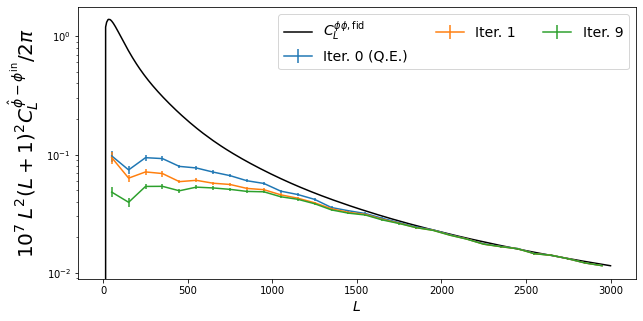

In [5]:
ell, = np.where(itlib.lib_qlm.get_Nell()[:3001])
w = lambda ell : ell ** 2 * (ell + 1.) ** 2 /2./np.pi * 1e7
edges = np.arange(0, 3100, 100)
bl = edges[:-1];bu = edges[1:] 

sims = li.get_maps_lib('S4', 10, 11)
plm_input = itlib.lib_qlm.udgrade(sims.lencmbs.lib_skyalm, sims.lencmbs.get_sim_plm(0))
bnd_cl = lambda cl : li.misc.misc_utils.binned(cl, ell, bl, bu, w=w, return_err=True)
pl.figure(figsize= (10,5))
for it in [0, 1, 9]:
    cl, err = bnd_cl(itlib.lib_qlm.alm2cl(itlib.get_Plm(it, 'p') - plm_input)) 
    pl.errorbar(0.5 * bl + 0.5 * bu, cl, yerr=err, label='Iter. %s'%it + (it == 0) * ' (Q.E.)')
pl.plot(ell, li.get_fidcls()[0]['pp'][ell] * w(ell), c='k', label=r'$C_L^{\phi\phi, \rm fid}$')
pl.ylabel(r'$10^7\: L^2(L + 1)^2 C^{\hat \phi - \phi^{\rm in}}_L /2 \pi$', fontsize=20)
pl.xlabel(r'$L$', fontsize=14)
pl.legend(ncol=3, fontsize=14)
pl.semilogy()

### This file contains very crude information on the iterator work and likelihood gradient amplitudes:

In [6]:
cat /Users/jcarron/PyCharmProjects/lensit/temp/iterator_S4_sim000/history_increment.txt

cat: /Users/jcarron/PyCharmProjects/lensit/temp/iterator_S4_sim000/history_increment.txt: No such file or directory


### Lensing maps: 
we plot the deflection $\hat \alpha_{LM} = \sqrt{L (L + 1)} \hat \phi_{LM}$

(Text(0.5, 1.0, '$\\alpha^{\\rm input}$'), (-0.5, 1023.5, 1023.5, -0.5))

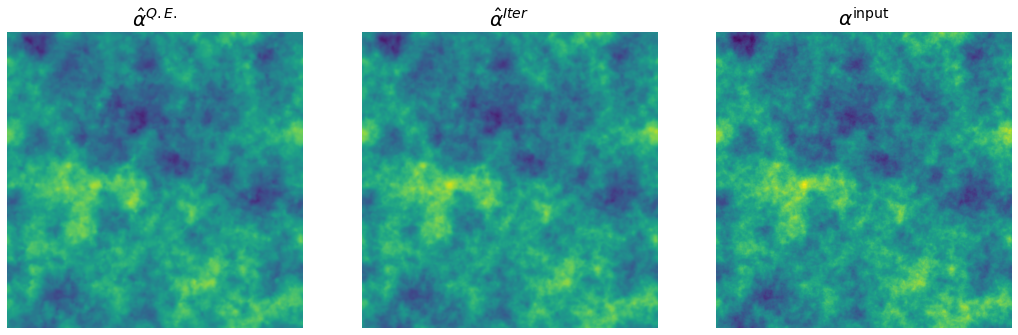

In [8]:
plm2alphalm = lambda plm : lib_qlm.almxfl(plm, np.arange(lib_qlm.ellmax + 1))
fig, ax = pl.subplots(1, 3, figsize=(18, 6),)
vmax = np.max(np.abs(lib_qlm.alm2map(plm2alphalm(plm_input))))
ax[0].imshow(lib_qlm.alm2map(plm2alphalm(itlib.get_Plm(0, 'p'))), vmax=vmax, vmin=-vmax)
ax[1].imshow(lib_qlm.alm2map(plm2alphalm(itlib.get_Plm(9, 'p'))), vmax=vmax, vmin=-vmax)
ax[2].imshow(lib_qlm.alm2map(plm2alphalm(plm_input)), vmax=vmax, vmin=-vmax)
ax[0].set_title(r'$\hat \alpha^{Q.E.}$', fontsize=20), ax[0].axis('off')
ax[1].set_title(r'$\hat \alpha^{Iter}$', fontsize=20), ax[1].axis('off')
ax[2].set_title(r'$\alpha^{\rm input}$', fontsize=20), ax[2].axis('off')